# Libs

In [2]:
import math
import warnings

import numpy as np
import arviz as az
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.special as sc
import theano.tensor as tt
import matplotlib.pyplot as plt
from scipy import stats
#from theano import shared, function
#from pymc3.distributions.dist_math import betaln, bound

from custom import pert

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC v3.11.4
Running on ArviZ v0.11.2


# Testing

Тут просто тестирование библиотек

## Normal Test

In [29]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

In [7]:
values = np.linspace(-5, 5, 1000)
probs = np.array([np.exp(x.logp({"x": i})) for i in values])
#probs

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

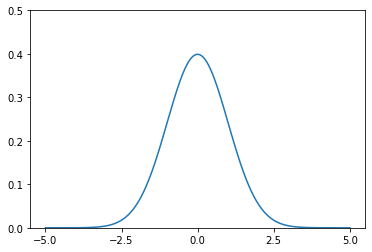

In [27]:
fig, ax = plt.subplots()
ax.set_ylim(0, 0.5)
ax.set_xticks(np.linspace(-5, 5, 5))
ax.plot(values, probs)
plt.plot

## Beta Test

In [27]:
with pm.Model():
    x_beta = pm.Beta("x_beta", alpha=1.8, beta=4.2, transform=None)

In [30]:
beta_values = np.linspace(0, 1, 1000)
beta_probs = np.array([np.exp(x_beta.logp({"x_beta": i})) for i in beta_values])
#probs

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

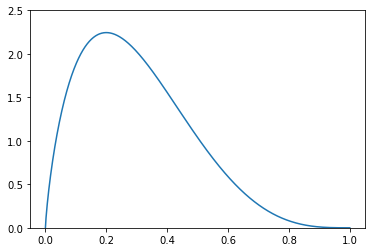

In [32]:
fig, ax = plt.subplots()
ax.set_ylim(0, 2.5)
ax.set_xticks(np.linspace(0, 1, 6))
ax.plot(beta_values, beta_probs)
plt.plot

## Theano Test

In [38]:
#x = tt.vector('x')
#f = function([x], x)
x = shared(np.linspace(1, 6, 1000))
#x = 3
#function([list(np.linspace(0, 5, 10000))])
x.get_value()

array([1.        , 1.00500501, 1.01001001, 1.01501502, 1.02002002,
       1.02502503, 1.03003003, 1.03503504, 1.04004004, 1.04504505,
       1.05005005, 1.05505506, 1.06006006, 1.06506507, 1.07007007,
       1.07507508, 1.08008008, 1.08508509, 1.09009009, 1.0950951 ,
       1.1001001 , 1.10510511, 1.11011011, 1.11511512, 1.12012012,
       1.12512513, 1.13013013, 1.13513514, 1.14014014, 1.14514515,
       1.15015015, 1.15515516, 1.16016016, 1.16516517, 1.17017017,
       1.17517518, 1.18018018, 1.18518519, 1.19019019, 1.1951952 ,
       1.2002002 , 1.20520521, 1.21021021, 1.21521522, 1.22022022,
       1.22522523, 1.23023023, 1.23523524, 1.24024024, 1.24524525,
       1.25025025, 1.25525526, 1.26026026, 1.26526527, 1.27027027,
       1.27527528, 1.28028028, 1.28528529, 1.29029029, 1.2952953 ,
       1.3003003 , 1.30530531, 1.31031031, 1.31531532, 1.32032032,
       1.32532533, 1.33033033, 1.33533534, 1.34034034, 1.34534535,
       1.35035035, 1.35535536, 1.36036036, 1.36536537, 1.37037

In [52]:
alpha, beta = tt.vector('alpha'), tt.vector('beta')
alpha = shared(1)
beta = shared(2)
sc.beta(alpha.get_value(), beta.get_value())

0.5

# PERT

Попытка сделать кастомное PERT-распределение. По сути оно представляет из себя частный случай четырехпараметрического бета-распредления с двумя параметрами формы $\alpha$ и $\beta$ из двухпараметрического бета-распределения и еще двумя параметрами масштаба $a$ и $c$, которые задают область определения $min$ и $max$ распределения. Иными словами $x \in [a, c]$.

Но в PERT используются три параметра $a$, $b$ и $c$. $a$ и $c$ — это те же параметры из бета, то есть $min$ и $max$. Но форма задается не напрямую через параметры $\alpha$ и $\beta$, которые являются аргументами бета-функции, а через параметр $c$, котоорый является mode (модой?) распределения. Притом аргументы бета-функции $\alpha$ и $\beta$ можно вычислить по формулам:

$\alpha = 1 + 4 \dfrac{b - a}{c - a}$

$\beta = 1 + 4 \dfrac{c - b}{c - a}$

$PDF_{beta} = \dfrac{x^{\alpha - 1}(1 - x)^{\beta - 1}}{B(\alpha, \beta)}$

$PDF_{PERT} = \dfrac{(x - a)^{\alpha - 1}(c - x)^{\beta - 1}}{B(\alpha, \beta)(c - a)^{\alpha + \beta - 1}}$

Все формулы брал из таблички вики: https://en.wikipedia.org/wiki/PERT_distribution

## PERT Testing

In [5]:
with pm.Model():
    #BoundedPert = pm.Bound(Pert, lower=0, upper=5)
    #x = BoundedPert(name="x", a=0, b=2, c=5, transform=None)
    dist = pert(name="dist", a=0, b=2, c=5, transform=None)

In [6]:
x = np.linspace(0, 5, 10000)
y = np.array([np.exp(dist.logp({"dist": i})) for i in x])
#probs

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

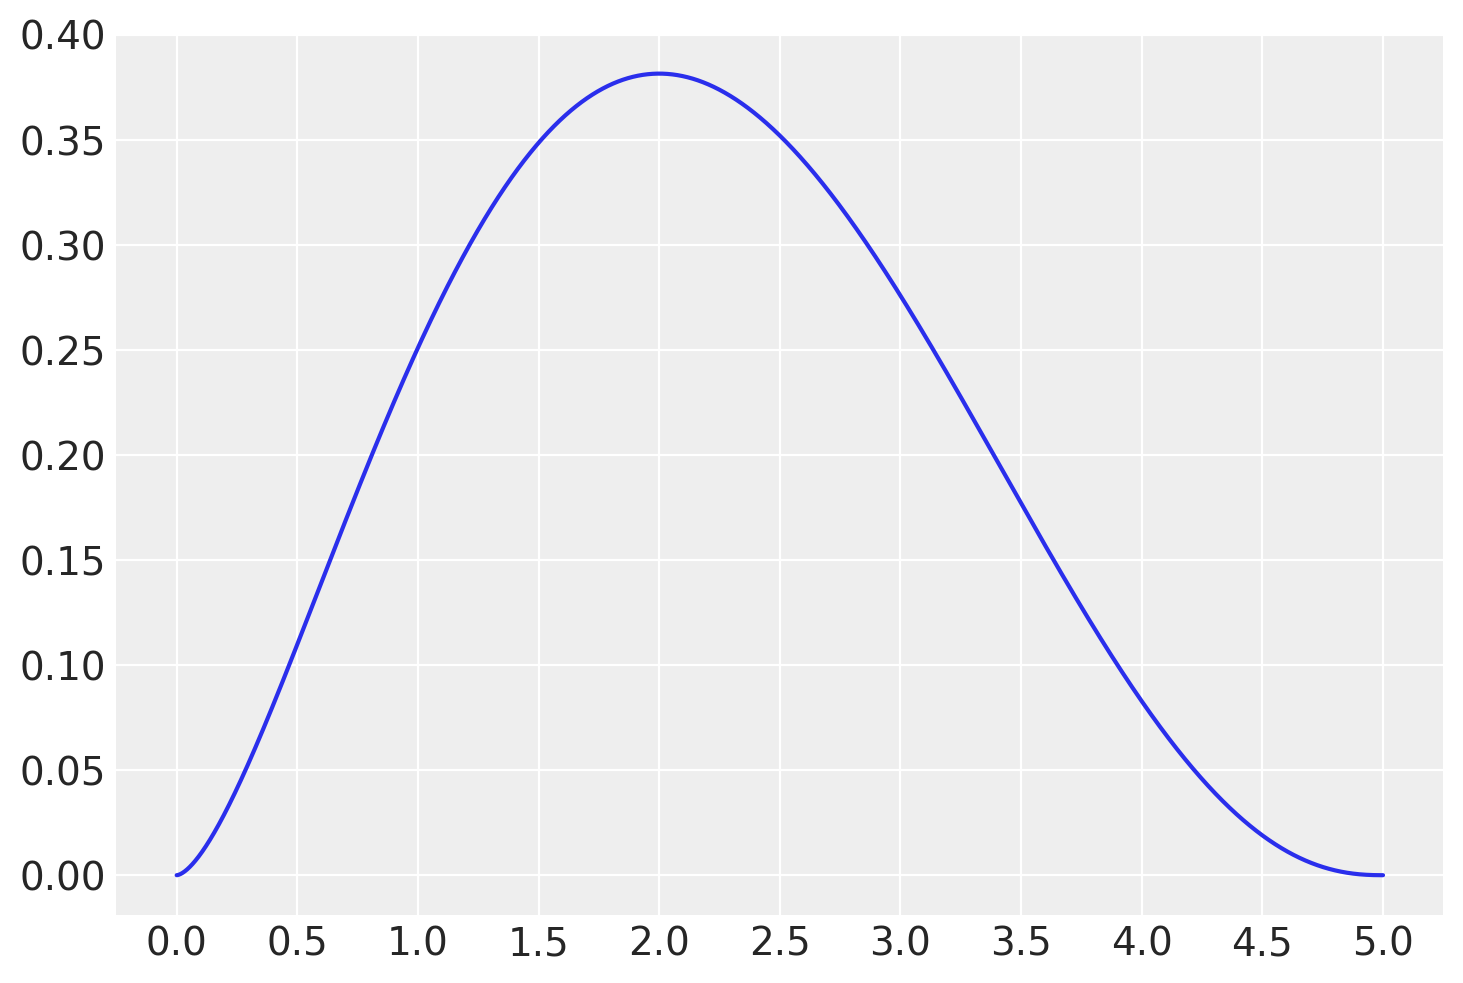

In [7]:
fig, ax = plt.subplots()
#ax.set_ylim(0, 2.5)
ax.set_xticks(np.linspace(0, 5, 11))
ax.plot(x, y)
plt.plot

# Trash

## Beta-function

Первый вариант: прописать PDF по формуле через бета-функцию

Здесь начинаются эксперименты с построением кастомного распределения. Для начала я попробовал воспользоваться формулой PDF из той же вики, которая является просто масштабируемой бета-функцией. Благо, в scipy она как раз встроена 

$\alpha = 1 + 4 \dfrac{b - a}{c - a}$

$\beta = 1 + 4 \dfrac{c - b}{c - a}$

$PDF_{PERT} = \dfrac{(x - a)^{\alpha - 1}(c - x)^{\beta - 1}}{B(\alpha, \beta)(c - a)^{\alpha + \beta - 1}}$

И сейчас все вроде бы заработало, потому что я разобрался с типизацией. Но работает не так, как надо, потому что на любое значение $x$ выдает $logp = - \infty$

In [74]:
with pm.Model():
    def logp(x):
        # здесь я сразу задаю theano скаляры для параметров, чтобы не было конфликтов
        a, b, c = tt.scalar('a'), tt.scalar('b'), tt.scalar('c')
        
        a = shared(0)
        b = shared(2)
        c = shared(5)
        
        alpha, beta = tt.scalar('alpha'), tt.scalar('beta')

        alpha = 1 + 4 * (b - a) / (c - a)  
        beta = 1 + 4 * (c - b) / (c - a)
        
        # отдельно считаю аргументы для функций, потому что numpy не нравятся вычисления внутри функции
        arg1 = x - a
        arg2 = c - x
        arg3 = c - a
        ab = alpha + beta

        coef = np.power(arg1, alpha-1) * np.power(arg2, beta-1) / np.power(arg3, ab-1)
        beta_function = shared(sc.beta(alpha.eval(), beta.eval())) # и тут получаю значения из скаляров, чтобы scipy мог с ними работать
        result = np.log(coef / beta_function)
        
        print(result.eval())
        print((coef / beta_function).eval())

        #print(x.eval())
        #print(coef.eval())
        #print(beta_function.eval())
        #print((np.log(coef / beta_function)).eval())

        return result

    x = np.linspace(0, 5, 1000)
    pert_dist = pm.DensityDist('pert_dist', logp, observed={'x':x})

/var/folders/dh/21zryz8x2nddglznzqt68jj40000gn/T/ipykernel_6866/85269389.py:23: RuntimeWarning: divide by zero encountered in log
  result = np.log(coef / beta_function)


[0.00000000e+00 8.91761131e-05 2.69681784e-04 5.14697027e-04
 8.13591907e-04 1.15988403e-03 1.54901434e-03 1.97751651e-03
 2.44262046e-03 2.94203423e-03 3.47381223e-03 4.03626994e-03
 4.62792594e-03 5.24746076e-03 5.89368676e-03 6.56552547e-03
 7.26199014e-03 7.98217206e-03 8.72522964e-03 9.49037958e-03
 1.02768897e-02 1.10840726e-02 1.19112813e-02 1.27579043e-02
 1.36233622e-02 1.45071049e-02 1.54086082e-02 1.63273724e-02
 1.72629194e-02 1.82147913e-02 1.91825488e-02 2.01657699e-02
 2.11640483e-02 2.21769924e-02 2.32042245e-02 2.42453798e-02
 2.53001054e-02 2.63680596e-02 2.74489114e-02 2.85423397e-02
 2.96480329e-02 3.07656881e-02 3.18950109e-02 3.30357150e-02
 3.41875213e-02 3.53501582e-02 3.65233607e-02 3.77068704e-02
 3.89004352e-02 4.01038088e-02 4.13167504e-02 4.25390250e-02
 4.37704024e-02 4.50106577e-02 4.62595705e-02 4.75169251e-02
 4.87825104e-02 5.00561191e-02 5.13375485e-02 5.26265993e-02
 5.39230765e-02 5.52267883e-02 5.65375469e-02 5.78551676e-02
 5.91794690e-02 6.051027

Притом когда я вывожу значения, то видно, что это тензор с вроде бы правдоподобными значениями вероятностей. Но почему-то при передаче аргумента при вызове функции возвращается нечто странное. Все значения становятся -inf, то есть для любого значения нулевая вероятность. И это даже тогда, когда я отдаю в модель тот же самый linspace, что в определении функции

In [75]:
pert_dist.logp({"x": 2})

array(-inf)

In [66]:
y = np.array([np.exp(pert_dist.logp({"x": i})) for i in x])
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1,)

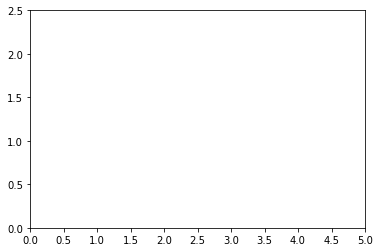

In [12]:
fig, ax = plt.subplots()
ax.set_ylim(0, 2.5)
ax.set_xticks(np.linspace(0, 5, 11))
ax.plot(x, y)
plt.plot

## Beta-distribution

Попытка номер два: прописать PDF без бета-функции напрямую, а воспользовавшись $logp$ из готового двухпараметрического бета-распределения PyMC, так как PERT представляет из себя скейлинг беты

$\alpha = 1 + 4 \dfrac{b - a}{c - a}$

$\beta = 1 + 4 \dfrac{c - b}{c - a}$

$PDF_{beta} = \dfrac{x^{\alpha - 1}(1 - x)^{\beta - 1}}{B(\alpha, \beta)}$

$PDF_{PERT} = \dfrac{\left(1 - \dfrac{x}{a}\right)^{\alpha - 1}\left(1 + \dfrac{c - 1}{1 - x}\right)^{\beta - 1}}{\left(c - a\right)^{\alpha + \beta - 1}} \cdot PDF_{beta}$

Не работает вообще ничего, но уже вроде и не надо, так как появились подвижки в первом варианте

$\ln{x^{\alpha - 1}} = (\alpha - 1) \ln{x}$

In [ ]:
with pm.Model():
    def logp(x):        
        a = shared(1)
        b = shared(3)
        c = shared(6)
        #print(a.type)

        alpha = 1 + 4 * (b - a) / (c - a)
        beta = 1 + 4 * (c - b) / (c - a)
        #print(alpha.type)
            
        arg1 = 1 - x / a
        arg2 = 1 + (c - 1) / (1 - x)
        arg3 = c - a
        ab = alpha + beta
        
        beta_dist = pm.Beta("beta_dist", alpha=alpha, beta=beta, transform=None)
        beta_logp = beta_dist.logp(x)
        print(beta_logp.type)
        
        coef = np.power(arg1, alpha-1) * np.power(arg2, beta-1) / np.power(arg3, ab-1)
        #print(coef.type)
        return (beta_logp + np.log(coef)).sum()
    
    x = 3
    pert_dist = pm.DensityDist('pert_dist', logp, observed={'x':x})

TypeError: can't turn [Sum{acc_dtype=float64}.0] and {} into a dict. TensorType does not support iteration. Maybe you are using builtins.sum instead of theano.tensor.sum? (Maybe .max?)

## More Trash

In [92]:
    def logp(x, a, b, c):
        alpha = 1 + 4 * (b - a) / (c - a)
        print('alpha = ' + str(alpha))
        
        beta = 1 + 4 * (c - b) / (c - a)
        print('beta = ' + str(beta))
        
        x_a = x - a
        c_x = c - x
        c_a = c - a
        alpha_beta = alpha + beta
        
        coef = np.power(x_a, alpha-1) * np.power(c_x, beta-1) / np.power(c_a, alpha_beta-1)
        print('coef = ' + str(coef))
        
        beta_function = sc.beta(2.6, 3.4)
        print('beta_function = ' + str(beta_function))
        
        return np.log(coef / beta_function)

    logp(1, 0, 2, 5)

alpha = 2.6
beta = 3.4
coef = 0.00891443776815231
beta_function = 0.03551671602333521


-1.3823312760524398

In [95]:
pdf = np.exp(logp(np.linspace(0, 5, 100000), 0, 2, 5))

/var/folders/dh/21zryz8x2nddglznzqt68jj40000gn/T/ipykernel_37266/2651416748.py:13: RuntimeWarning: divide by zero encountered in log
  return np.log(coef / beta_function)


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

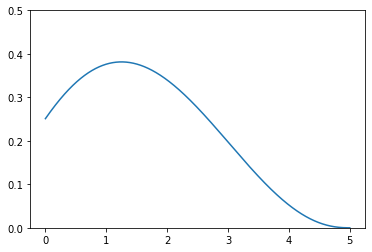

In [111]:
fig, ax = plt.subplots()
ax.set_ylim(0, .5)
ax.set_xticks(np.linspace(0, 5, 6))
ax.plot(np.linspace(0, 5, 100000), pdf)
plt.plot

In [90]:
np.power(np.random.rand(2) - np.random.rand(2), np.random.rand(2)-1)

/var/folders/dh/21zryz8x2nddglznzqt68jj40000gn/T/ipykernel_37266/1040721448.py:1: RuntimeWarning: invalid value encountered in power
  np.power(np.random.rand(2) - np.random.rand(2), np.random.rand(2)-1)


array([nan, nan])

In [78]:
sc.beta(np.random.rand(2), np.random.rand(2))

array([2.48970422, 7.28520299])